# How Tiny Neural Networks Represent Basic Functions
*A Gentle Introduction to Mechanistic Interpretability Through Simple Algorithmic Examples*

---

# Setup

In [ ]:
# @title Install non standard packages with pip

!pip3 install torchview
!pip3 install pygad
!pip3 install torchga

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torchga (from versions: none)
ERROR: No matching distribution found for torchga


In [ ]:
# @title Imports
import datetime
import copy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from dataclasses import dataclass
import dataclasses

from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import tqdm

from typing import List, Dict

from torchview import draw_graph

In [ ]:
# @title Utilities

def draw_2d(x: List[float], labels_dict: Dict[str, List[float]]):
  """ Draws graph with multiple labels"""
  return pd.DataFrame({'x': np.array(x).reshape(-1), **labels_dict})\
    .set_index('x').plot(linewidth=3)

def draw_3d(x_2d , labels_dict):
  """ Draws wite multiple labels"""
  assert type(labels_dict) == dict
  x, y = list(map(list, zip(*x_2d))) # Separate tuples to 2 lists.
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.set_box_aspect(aspect=None, zoom=0.8) # zoom out so labels won't be chopped
  ax.set_zlabel('Ground Truth', rotation=90)
  z = next(iter(labels_dict.values())) # TODO, support more than 1
  ax.scatter3D(x, y, z, c=z)
  ax.invert_xaxis()

def torch_tensor(x):
  return torch.tensor(x).float()

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.X = x
        self.Y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


def l1_regularizer(model, rate):
    loss = 0
    for matrix in model.parameters():
      loss += rate * matrix.abs().sum()
    return loss

def train_model(model,
                x, y,
                patience=-1,
                num_epochs=1000,
                batch_size=8,
                normalize=False,
                learning_rate=1e-4,
                weight_decay=0,
                l1_reg_lambda=0,
                print_every=1000):
  """
  Trains the `model` and returns it. Also returns the x, y data normalizers
  if they are used or None
  """

  writer = SummaryWriter(
      "runs/torch/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  loss_fn = nn.MSELoss()
  # loss_fn = nn.L1Loss()

  optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  # optimizer = torch.optim.SGD(
  #   model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # Normalize for better training
  x_norm, y_norm = x, y
  x_normalizer, y_normalizer = None, None
  if normalize:
    x_normalizer, y_normalizer = MinMaxScaler(), MinMaxScaler()
    x_norm = torch_tensor(x_normalizer.fit_transform(x))
    y_norm = torch_tensor(y_normalizer.fit_transform(y))
  train_dataset = MyDataset(x_norm, y_norm)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # CUDA for PyTorch
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  torch.backends.cudnn.benchmark = True
  model.to(device)

  # Train the model
  losses = []
  for epoch in tqdm.tqdm(range(num_epochs)):
    loss = 0
    for batch_x, batch_y in train_loader:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)
      y_pred = model(batch_x)

      loss = loss_fn(y_pred, batch_y) + l1_regularizer(model, rate=l1_reg_lambda)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if (epoch+1) % print_every == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    writer.add_scalar("Loss", loss, epoch)
    losses.append(loss)
    if patience > 0 and len(losses) > patience and all(
        losses[-patience] <= x\
        for x in losses[-patience + 1:]):
      print("EarlyStopping")
      break

  writer.add_graph(model, torch_tensor(x[0]))
  writer.flush()
  writer.close()
  return model, x_normalizer, y_normalizer

def normalize_and_predict(x,
                          x_normalizer: MinMaxScaler | None,
                          y_normalizer: MinMaxScaler | None,
                          model):
  if x_normalizer:
    x = torch_tensor(x_normalizer.transform(x))
  y_pred = model(x).detach()
  if y_normalizer:
    y_pred = y_normalizer.inverse_transform(y_pred)
  return y_pred

# Article

## x < 10
---

<Axes: xlabel='x'>

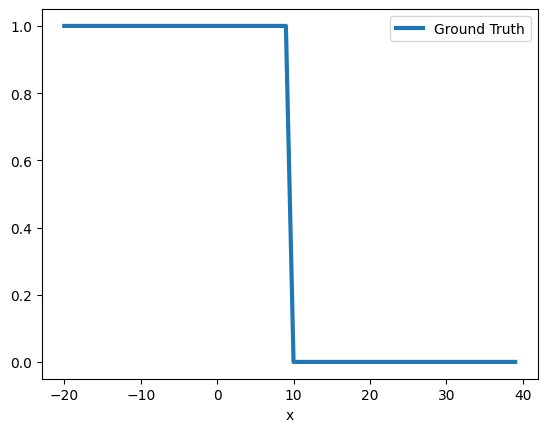

In [ ]:
# @title Dataset
X = [[i] for i in range(-20, 40)]
Y = [1 if z[0] < 10 else 0 for z in X]
draw_2d(X, {'Ground Truth': Y})

<Axes: xlabel='x'>

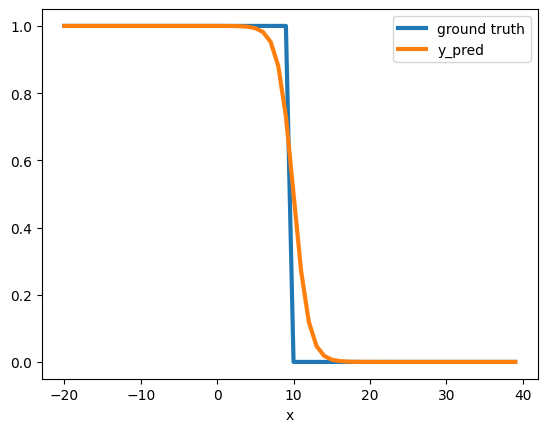

In [ ]:
# @title With hard wired weights
model = nn.Sequential(nn.Linear(1,1), nn.Sigmoid())
d = model.state_dict()
d["0.weight"] = torch.tensor([[-1]]).float()
d['0.bias'] = torch.tensor([10]).float()
model.load_state_dict(d)
y_pred = model(torch_tensor(X)).detach().reshape(-1)
draw_2d(X, {'ground truth': torch_tensor(Y).reshape(-1), 'y_pred': y_pred})

 10%|█         | 1032/10000 [00:06<00:33, 266.33it/s]

Epoch [1000/10000], Loss: 0.0190


 20%|██        | 2045/10000 [00:11<00:24, 328.27it/s]

Epoch [2000/10000], Loss: 0.0126


 31%|███       | 3072/10000 [00:14<00:15, 449.81it/s]

Epoch [3000/10000], Loss: 0.0095


 41%|████      | 4096/10000 [00:16<00:12, 469.55it/s]

Epoch [4000/10000], Loss: 0.0075


 51%|█████     | 5064/10000 [00:18<00:10, 478.47it/s]

Epoch [5000/10000], Loss: 0.0060


 61%|██████    | 6077/10000 [00:20<00:08, 469.46it/s]

Epoch [6000/10000], Loss: 0.0048


 70%|███████   | 7048/10000 [00:22<00:06, 473.75it/s]

Epoch [7000/10000], Loss: 0.0039


 81%|████████  | 8070/10000 [00:25<00:05, 345.96it/s]

Epoch [8000/10000], Loss: 0.0030


 91%|█████████ | 9058/10000 [00:28<00:01, 482.05it/s]

Epoch [9000/10000], Loss: 0.0023


100%|██████████| 10000/10000 [00:30<00:00, 332.34it/s]
<ipython-input-3-56eee18e8992>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x).float()


Epoch [10000/10000], Loss: 0.0017
CPU times: user 25.9 s, sys: 955 ms, total: 26.9 s
Wall time: 35.6 s


<Axes: xlabel='x'>

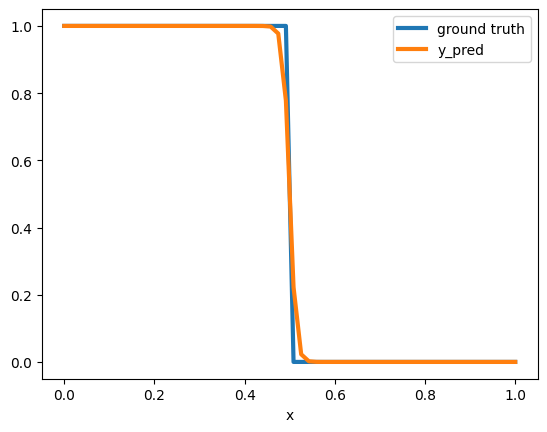

In [ ]:
%%time

# @title Train
x, y = torch_tensor(X), torch_tensor(Y).reshape([-1, 1])
model = nn.Sequential(nn.Linear(1,1), nn.Sigmoid())
model, x_preprocess, _ = train_model(
    model=model, x=x, y=y, num_epochs=10000, l1_reg_lambda=0,
    learning_rate=1e-1, batch_size=512, normalize=True)
x = torch_tensor(x_preprocess.transform(X))
y_pred = model(x).detach().reshape(-1)
draw_2d(x, {'ground truth': y.reshape(-1),'y_pred': y_pred})

## Min(a,b)
---

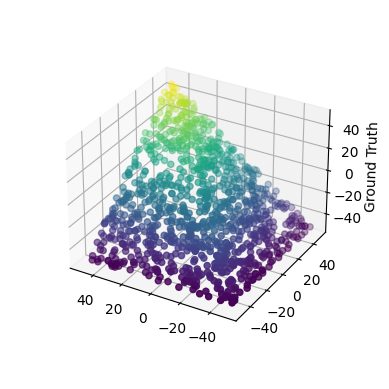

In [ ]:
# @title Dataset

X_2D = [[random.randrange(-50, 50), random.randrange(-50, 50)] for i in range (1000)]
Y = [min(a,b) for a, b in X_2D]
draw_3d(X_2D, {"ground_truth": Y})

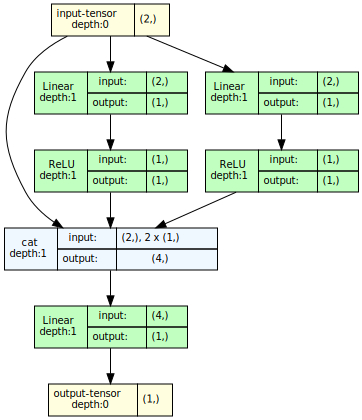

In [ ]:
# @title Model

class MinModel(nn.Module):
  """Create a model that has the capability to learn the function
  0.5(a + b - ReLU(b - a) - ReLU(a - b)).
  """
  def __init__(self):
      super(MinModel, self).__init__()

      # For ReLU(a-b)
      self.fc1 = nn.Linear(2, 1)
      self.relu1 = nn.ReLU()
      # For ReLU(b-a)
      self.fc2 = nn.Linear(2, 1)
      self.relu2 = nn.ReLU()
      # Takes 4 components [a, b, ReLU(a-b), ReLU(b-a)]
      self.output_layer = nn.Linear(4, 1)

  def forward(self, x):
      relu_output1 = self.relu1(self.fc1(x))
      relu_output2 = self.relu2(self.fc2(x))
      return self.output_layer(
          torch.cat((x, relu_output1, relu_output2), dim=-1))

model = MinModel()
_ = model(torch_tensor(X_2D[0])) # Run one layer to make sure nothing crashes.
draw_graph(model, input_size=(2,), expand_nested=True).visual_graph

 17%|█▋        | 51/300 [00:07<00:32,  7.73it/s]

Epoch [50/300], Loss: 1.1310


 34%|███▎      | 101/300 [00:14<00:26,  7.38it/s]

Epoch [100/300], Loss: 0.7941


 50%|█████     | 151/300 [00:22<00:19,  7.50it/s]

Epoch [150/300], Loss: 0.7764


 67%|██████▋   | 201/300 [00:30<00:18,  5.27it/s]

Epoch [200/300], Loss: 0.7683


 84%|████████▎ | 251/300 [00:38<00:06,  7.30it/s]

Epoch [250/300], Loss: 0.7661


100%|██████████| 300/300 [00:46<00:00,  6.49it/s]
<ipython-input-3-56eee18e8992>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x).float()


Epoch [300/300], Loss: 0.7660
CPU times: user 44.4 s, sys: 315 ms, total: 44.7 s
Wall time: 46.4 s


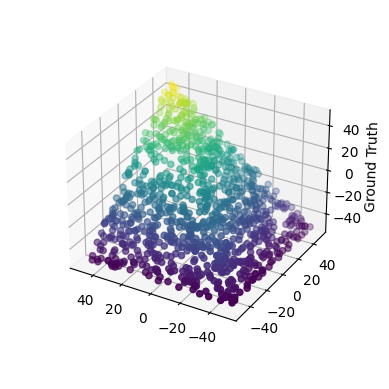

In [ ]:
%%time

# @title Train
x, y = torch_tensor(X_2D), torch_tensor(Y).reshape([-1, 1])
model, _, _ = train_model(
    model=model, x=x, y=y, num_epochs=300, l1_reg_lambda=0.2,
    learning_rate=1e-3, batch_size=16, normalize=False, print_every=50)
y_pred = normalize_and_predict(x, None, None, model)
draw_3d(x, {'y_pred': y_pred})

In [ ]:
# @title Clean Weights
for k, v in model.state_dict().items():
  print(k, ": ", torch.round(v, decimals=2).numpy())

fc1.weight :  [[-0. -0.]]
fc1.bias :  [-0.]
fc2.weight :  [[ 0.72 -0.72]]
fc2.bias :  [-0.]
output_layer.weight :  [[ 1.  -0.   0.  -1.4]]
output_layer.bias :  [0.]


## is_even(x)
---

<Axes: xlabel='x'>

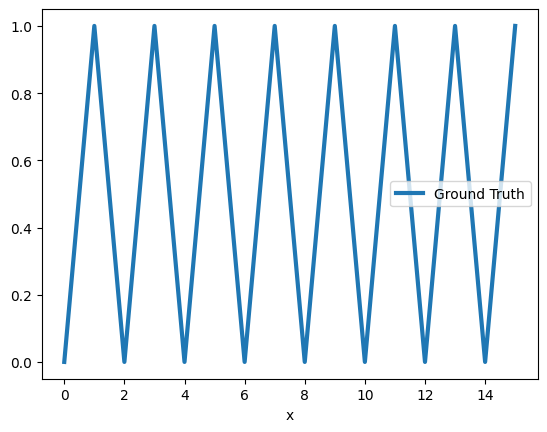

In [ ]:
# @title First lets create sample data which we will then try to learn
X = [[i] for i in range(0, 16)]
Y = [z[0] % 2 for z in X]
draw_2d(X, {'Ground Truth': Y})

In [ ]:
# @title Create the model

# The list of layers - first / last layers should match the input / output sizes
###@param {'type': 'string'}
# layers_list = "[1,2,2,2,2,2,1]"
# layers_list = eval(layers_list)

def create_sequential_model(layers_list = [1,2,2,2,2,2,1]):
  layers = []
  for i in range(1, len(layers_list)):
      layers.append(nn.Linear(layers_list[i-1], layers_list[i]))
      layers.append(nn.ReLU())
  return nn.Sequential(*layers)

# Create the fully connected model
model = create_sequential_model()
model(torch_tensor(X[0])) # Run one layer to make sure nothing crashes.
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=2, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2, out_features=2, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2, out_features=2, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2, out_features=2, bias=True)
  (9): ReLU()
  (10): Linear(in_features=2, out_features=1, bias=True)
  (11): ReLU()
)


In [ ]:
# @title Set weights explicitly

# This weight matrix implements |ABS| using to ReLU neurons.
# Relu(-(x-b)) + Relu(x-b)
abs_weight_matrix = torch_tensor([[-1, -1],
                                  [1, 1]])
# Return the pair of biases used for each of the ReLUs.
get_relu_bias = lambda b: torch_tensor([b, -b])

d = model.state_dict()
d['0.weight'], d['0.bias'] = torch_tensor([[-1],[1]]), get_relu_bias(8)
d['2.weight'], d['2.bias'] = abs_weight_matrix, get_relu_bias(4)
d['4.weight'], d['4.bias'] = abs_weight_matrix, get_relu_bias(2)
d['6.weight'], d['6.bias'] = abs_weight_matrix, get_relu_bias(1)
d['8.weight'], d['8.bias'] = abs_weight_matrix, get_relu_bias(1)
d['10.weight'], d['10.bias'] = torch_tensor([[1, 1]]), torch_tensor([0])
model.load_state_dict(d)
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-1.],
                      [ 1.]])),
             ('0.bias', tensor([ 8., -8.])),
             ('2.weight',
              tensor([[-1., -1.],
                      [ 1.,  1.]])),
             ('2.bias', tensor([ 4., -4.])),
             ('4.weight',
              tensor([[-1., -1.],
                      [ 1.,  1.]])),
             ('4.bias', tensor([ 2., -2.])),
             ('6.weight',
              tensor([[-1., -1.],
                      [ 1.,  1.]])),
             ('6.bias', tensor([ 1., -1.])),
             ('8.weight',
              tensor([[-1., -1.],
                      [ 1.,  1.]])),
             ('8.bias', tensor([ 1., -1.])),
             ('10.weight', tensor([[1., 1.]])),
             ('10.bias', tensor([0.]))])

<Axes: xlabel='x'>

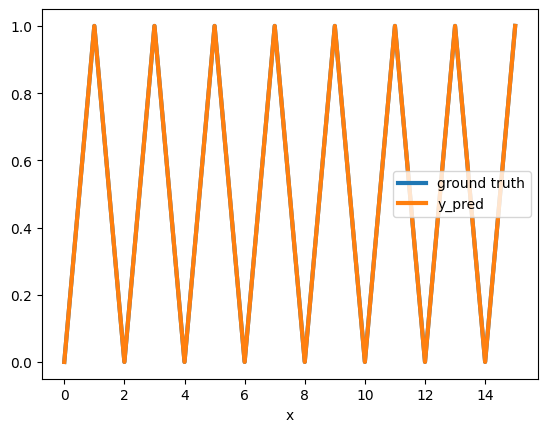

In [ ]:
# @title Predict and draw (in domain)
y_pred = model(torch_tensor(X)).detach().reshape(-1)
draw_2d(X, {'ground truth': torch_tensor(Y).reshape(-1),'y_pred': y_pred})

<Axes: xlabel='x'>

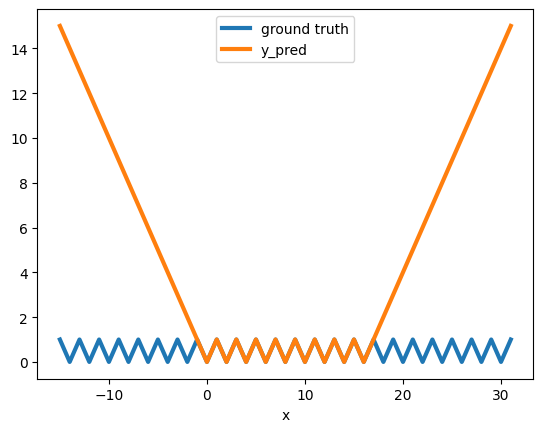

In [ ]:
# @title Predict and draw (out domain)
X = [[i] for i in range(-15, 32)]
Y = [z[0] % 2 for z in X]
y_pred = model(torch_tensor(X)).detach().reshape(-1)
draw_2d(X, {'ground truth': torch_tensor(Y).reshape(-1),'y_pred': y_pred})

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1003/10000 [00:23<04:58, 30.14it/s]

Epoch [1000/10000], Loss: 0.3788


 20%|██        | 2008/10000 [00:45<03:07, 42.73it/s]

Epoch [2000/10000], Loss: 0.2617


 30%|███       | 3007/10000 [01:09<02:29, 46.69it/s]

Epoch [3000/10000], Loss: 0.2501


 40%|████      | 4006/10000 [01:33<02:08, 46.65it/s]

Epoch [4000/10000], Loss: 0.2555


 50%|█████     | 5006/10000 [01:57<01:46, 46.86it/s]

Epoch [5000/10000], Loss: 0.2519


 60%|██████    | 6005/10000 [02:19<01:56, 34.25it/s]

Epoch [6000/10000], Loss: 0.2497


 70%|███████   | 7006/10000 [02:45<01:03, 47.21it/s]

Epoch [7000/10000], Loss: 0.2487


 80%|███████▉  | 7999/10000 [03:10<00:41, 48.63it/s]

Epoch [8000/10000], Loss: 0.2488


 90%|█████████ | 9007/10000 [03:35<00:24, 41.23it/s]

Epoch [9000/10000], Loss: 0.2454


100%|██████████| 10000/10000 [04:03<00:00, 41.01it/s]
<ipython-input-3-56eee18e8992>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x).float()


Epoch [10000/10000], Loss: 0.2478
CPU times: user 3min 49s, sys: 2.67 s, total: 3min 52s
Wall time: 4min 4s


<Axes: xlabel='x'>

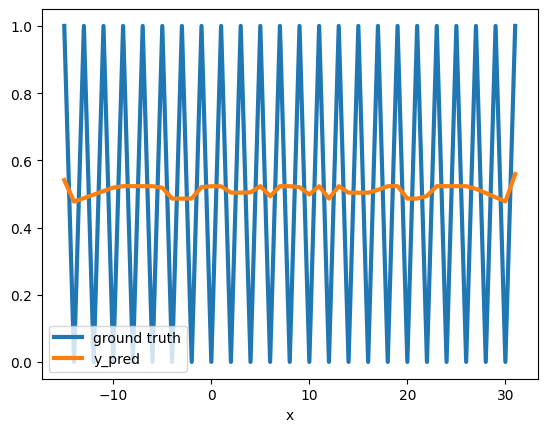

In [ ]:
%%time

# @title Train the model:
x, y = torch_tensor(X), torch_tensor(Y)
model, _, _ = train_model(
    model=model, x=x, y=y, num_epochs=10000, l1_reg_lambda=0, learning_rate=1e-4,
    batch_size=8)
y_pred = model(x).detach()
draw_2d(x, {'ground truth': y.reshape(-1),'y_pred': y_pred.reshape(-1)})
# draw_3d(X_2D, {"ground truth": y_pred.detach()})

# Tensorboard

In [ ]:
# @title Run tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
# Cleanup
!rm -R ./runs